# Predicting Electrical Energy Output with Regression Analysis
<hr>

### Overview

- [Introducing a simple linear regression model](#Introducing-a-simple-linear-regression-model)
- [Exploring the Dataset](#Exploring-the-Dataset)
  - [Visualizing the important characteristics of a dataset](#Visualizing-the-important-characteristics-of-a-dataset)
- [Implementing an ordinary least squares linear regression model](#Implementing-an-ordinary-least-squares-linear-regression-model)
  - [Solving regression for regression parameters with gradient descent](#Solving-regression-for-regression-parameters-with-gradient-descent)
  - [Estimating the coefficient of a regression model via scikit-learn](#Estimating-the-coefficient-of-a-regression-model-via-scikit-learn)
- [Fitting a robust regression model using RANSAC](#Fitting-a-robust-regression-model-using-RANSAC)
- [Evaluating the performance of linear regression models](#Evaluating-the-performance-of-linear-regression-models)
- [Using regularized methods for regression](#Using-regularized-methods-for-regression)
- [Modeling nonlinear relationships in the dataset](#Modeling-nonlinear-relationships-in-the-dataset)
- [Dealing with nonlinear relationships using random forests](#Dealing-with-nonlinear-relationships-using-random-forests)
    - [Decision tree regression](#Decision-tree-regression)
    - [Random forest regression](#Random-forest-regression)
- [Summary](#Summary)

Regression models are used to predict target variables on a continuous scale,
which makes them attractive for addressing many questions in science as well as
applications in industry, such as understanding relationships between variables,
evaluating trends, or making forecasts. One example would be predicting the sales
of a company in future months.

## Introducing a simple linear regression model

The goal of simple (univariate) linear regression is to model the relationship between
a single feature (explanatory variable x) and a continuous valued response (target
variable y). The equation of a linear model with one explanatory variable is defined
as follows:

y = w0 + w1x

Here, the weight 0 w represents the y axis intercepts and 1 w is the coefficient of
the explanatory variable. Our goal is to learn the weights of the linear equation to
describe the relationship between the explanatory variable and the target variable,
which can then be used to predict the responses of new explanatory variables that
were not part of the training dataset.

Based on the linear equation that we defined previously, linear regression can be
understood as finding the best-fitting straight line through the sample points, as
shown in the following figure:

<img src = "images/simple_linear_regression.png">

[[image source]](https://github.com/rasbt/python-machine-learning-book/tree/master/images/image_gallery)

This best-fitting line is also called the regression line, and the vertical lines from the
regression line to the sample points are the so-called offsets or residuals—the errors
of our prediction.

We can also generalize the linear regression model to multiple explanatory variables. Hence, this process is called multiple linear regression.

## Exploring the Dataset

Before we implement our first linear regression model, we will introduce a new
dataset, the CCPP ( Combined Cycle Power Plant) Dataset. 

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, The other three of the ambient variables affect the GT performance.

#### You can download the dataset from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip).


The dataset contains 4 attributes (or features, denoted by T, AP, RH, V) and one respone (or outcome, denoted by EP which is the Electrical Energy Output). The aim is to use the eight features to predict the response. 

Features consist of hourly average ambient variables 
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
- Net hourly electrical energy output (EP) 420.26-495.76 MW

The averages are taken from various sensors located around the plant that record the ambient variables every second. The 
variables are given without normalization.

Download the dataset zip file from the provided link and extract it in the current directory of your code. The dataset contains both the CSV file and the ODS file. We would be working withe the CSV file. 
After downloading the dataset, we load the data in a Pandas Dataframe using Pandas' read_csv() function.

In [1]:
import pandas as pd
# read .csv from provided dataset
csv_filename="CCPP/Folds5x2_pp.csv"

df=pd.read_csv(csv_filename)

In [2]:
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


## Visualizing the important characteristics of a dataset

Exploratory Data Analysis (EDA) is an important and recommended first step prior
to the training of a machine learning model. In the rest of this section, we will use
some simple yet useful techniques from the graphical EDA toolbox that may help
us to visually detect the presence of outliers, the distribution of the data, and the
relationships between features.

First, we will create a scatterplot matrix that allows us to visualize the pair-wise
correlations between the different features in this dataset in one place. To plot the
scatterplot matrix, we will use the pairplot function from the seaborn library
(http://stanford.edu/~mwaskom/software/seaborn/), which is a Python library
for drawing statistical plots based on matplotlib:

In [3]:
cols = df.columns

In [4]:
features=list(df.columns[:-1])

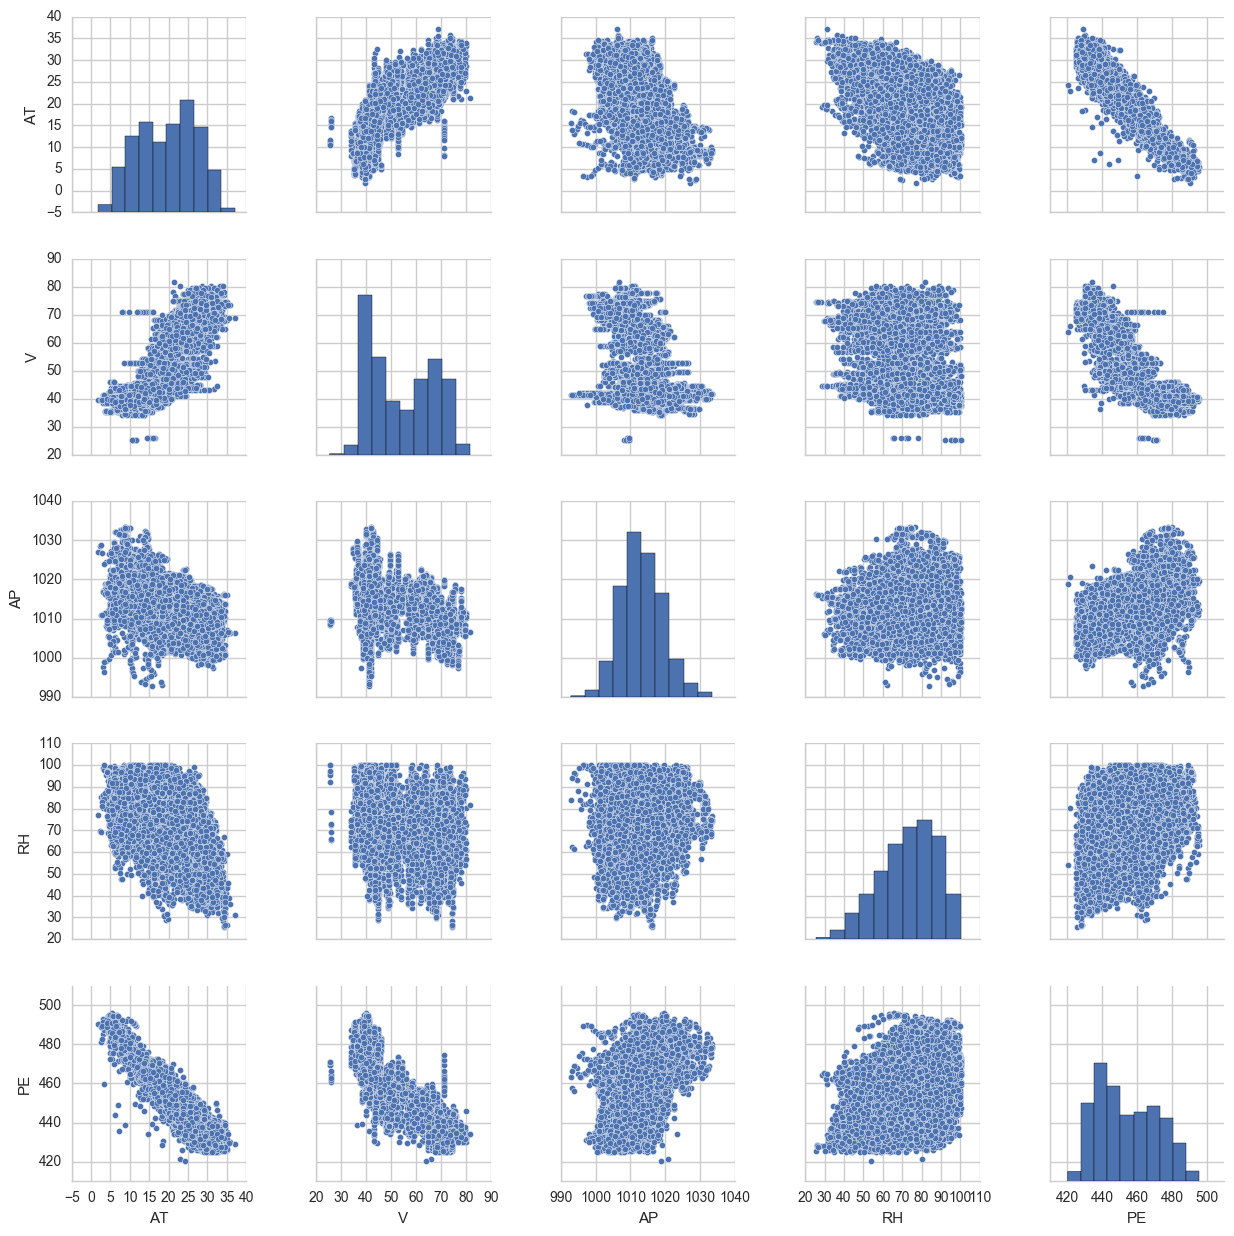

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

sns.pairplot(df, size=2.5);
plt.tight_layout()
# plt.savefig('./figures/scatter.png', dpi=300)
plt.show()

As we can see in the following figure, the scatterplot matrix provides us with a useful graphical summary of the relationships in a dataset.

Using this scatterplot matrix, we can now quickly eyeball how the data is distributed and whether it contains outliers. For example, we can see that there is a negative linear relationship between AT and the energy PE (the fifth column of the first row) and a slight linear relationship between AT and the V (the second column of the first row). To quantify the linear relationship between the features, we will now create a correlation matrix. Intuitively, we can interpret the correlation matrix as a rescaled version of the covariance matrix. In fact, the correlation matrix is identical to a covariance matrix computed from standardized data.

The correlation matrix is a square matrix that contains the Pearson product-moment correlation coefficients (often abbreviated as Pearson's r), which measure the linear dependence between pairs of features. The correlation coefficients are bounded to the range -1 and 1. Two features have a perfect positive correlation if r =1, no correlation if r = 0 , and a perfect negative correlation if r = −1, respectively.

In the following code example, we will use NumPy's corrcoef function on the five feature columns that we previously visualized in the scatterplot matrix, and we will use seaborn's heatmap function to plot the correlation matrix array as a heat map:

In [6]:
cols

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

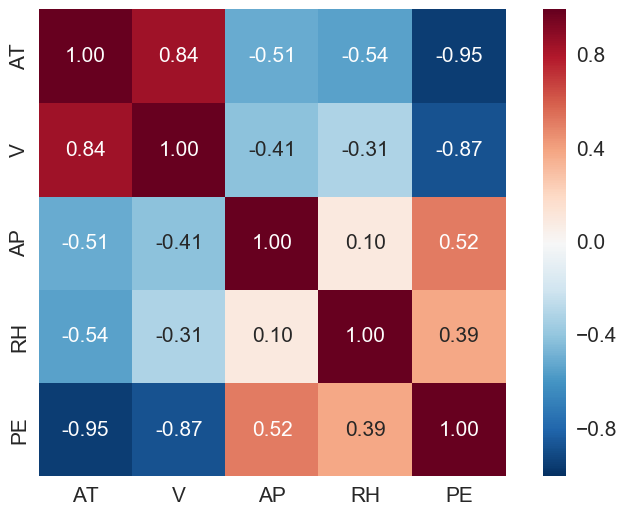

In [15]:
import numpy as np
cm = np.corrcoef(df.values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, 
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=cols.values,
            xticklabels=cols.values)

plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)
plt.show()

As we can see in the resulting figure, the correlation matrix provides us with another useful summary graphic that can help us to select features based on their respective linear correlations.

To fit a linear regression model, we are interested in those features that have a high correlation with our target variable PE. Looking at the preceding correlation matrix, we see that our target variable PE shows the largest correlation with the AT variable (-0.95). PE also shows a large correlation with the V variable (-0.87). However, as you might remember from the scatterplot matrix, there is a doubtful nonlinear relationship between V and PE. So given the linear relationship between PE and AT that we observed in the scatterplot, AT seems to be a good choice for an exploratory variable to introduce the concepts of a simple linear regression model in the following section.

In [16]:
sns.reset_orig()
%matplotlib inline

## Implementing an ordinary least squares linear regression model

At the beginning of this chapter, we discussed that linear regression can be
understood as finding the best-fitting straight line through the sample points of
our training data. However, we have neither defined the term best-fitting nor have
we discussed the different techniques of fitting such a model. In the following
subsections, we will fill in the missing pieces of this puzzle using the Ordinary
Least Squares (OLS) method to estimate the parameters of the regression line that
minimizes the sum of the squared vertical distances (residuals or errors) to the
sample points.

## Solving regression for regression parameters with gradient descent

In [17]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

To see our LinearRegressionGD regressor in action, let's use the AT (Atmospheric Temperature) variable from the CCPP Data Set as the explanatory variable to train a
model that can predict PE (Electrical Output). Furthermore, we will standardize
the variables for better convergence of the GD algorithm. The code is as follows:

In [28]:
X = df[['AT']].values
y = df['PE'].values

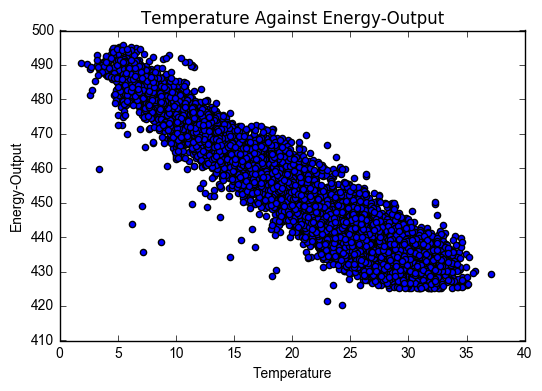

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(df['AT'], df['PE'])
plt.xlabel('Temperature')
plt.ylabel('Energy-Output')
plt.title('Temperature Against Energy-Output')
plt.show()

In [30]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

## Estimating the coefficient of a regression model via scikit-learn

In the previous section, we implemented a working model for regression
analysis. However, in a real-world application, we may be interested in more
efficient implementations, for example, scikit-learn's LinearRegression object
that makes use of the LIBLINEAR library and advanced optimization algorithms
that work better with unstandardized variables. This is sometimes desirable for
certain applications:

In [39]:
from sklearn.linear_model import LinearRegression

In [40]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: -2.171
Intercept: 497.034


As we can see by executing the preceding code, scikit-learn's LinearRegression
model fitted with the unstandardized variables yielded different
model coefficients. Let's plot PE against AT:

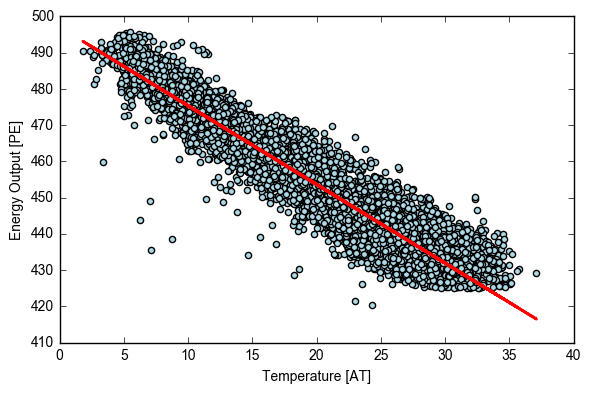

In [41]:
lin_regplot(X, y, slr)
plt.xlabel('Temperature [AT]')
plt.ylabel('Energy Output [PE]')
plt.tight_layout()
# plt.savefig('./figures/scikit_lr_fit.png', dpi=300)
plt.show()

## Fitting a robust regression model using RANSAC

Linear regression models can be heavily impacted by the presence of abnormal datapoints or outliers.
In certain situations, a very small subset of our data can have a big effect on the
estimated model coefficients. There are many statistical tests that can be used to
detect outliers, however, removing outliers always requires our own judgment as a data scientist, as well as our
domain knowledge.

As an alternative to throwing out outliers, we will look at a robust method of
regression using the RANdom SAmple Consensus (RANSAC) algorithm,
which fits a regression model to a subset of the data, the so-called inliers.
We can summarize the iterative RANSAC algorithm as follows:

1. Select a random number of samples to be inliers and fit the model.
2. Test all other data points against the fitted model and add those points that fall within a user-given tolerance to the inliers.
3. Refit the model using all inliers.
4. Estimate the error of the fitted model versus the inliers.
5. Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of iterations has been reached; go back to step 1 otherwise.

Let's now wrap our linear model in the RANSAC algorithm using scikit-learn's
RANSACRegressor object:

In [44]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         residual_metric=lambda x: np.sum(np.abs(x), axis=1), 
                         residual_threshold=5.0, 
                         random_state=0)
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

We set the maximum number of iterations of the RANSACRegressor to 100, and using
min_samples=50, we set the minimum number of the randomly chosen samples to
be at least 50. Using the residual_metric parameter, we provided a callable lambda
function that simply calculates the absolute vertical distances between the fitted line
and the sample points. By setting the residual_threshold parameter to 5.0, we
only allowed samples to be included in the inlier set if their vertical distance to the
fitted line is within 5 distance units, which works well on this particular dataset. By
default, scikit-learn uses the MAD estimate to select the inlier threshold, where MAD
stands for the Median Absolute Deviation of the target values y. However, the choice
of an appropriate value for the inlier threshold is problem-specific, which is one
disadvantage of RANSAC. 
After we have fitted the RANSAC model, let's obtain the inliers and outliers from the
fitted RANSAC linear regression model and plot them together with the linear fit:

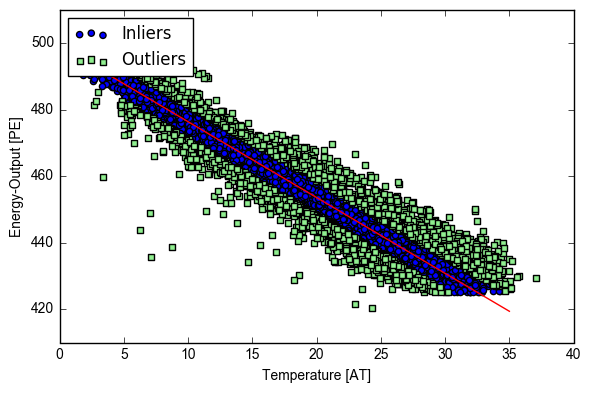

In [45]:
line_X = np.arange(2, 36, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Temperature [AT]')
plt.ylabel('Energy-Output [PE]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./figures/ransac_fit.png', dpi=300)
plt.show()

As we can see in the following scatterplot, the linear regression model was fitted on
the detected set of inliers shown as circles.

In [46]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: -2.281
Intercept: 499.207


When we print the slope and intercept of the model executing the following code,
we can see that the linear regression line is slightly different from the fit that we
obtained in the previous section without RANSAC:

Using RANSAC, we reduced the potential effect of the outliers in this dataset,
but we don't know if this approach has a positive effect on the predictive
performance for unseen data. Thus, in the next section we will discuss how to
evaluate a regression model for different approaches, which is a crucial part of
building systems for predictive modeling.

## Evaluating the performance of linear regression models

In the previous section, we discussed how to fit a regression model on training data.
However, you learned in previous chapters that it is crucial to test the model on data
that it hasn't seen during training to obtain an unbiased estimate of its performance.

We want to split our dataset into separate training and
test datasets where we use the former to fit the model and the latter to evaluate its
performance to generalize to unseen data. Instead of proceeding with the simple
regression model, we will now use all variables in the dataset and train a multiple
regression model:

In [47]:
from sklearn.cross_validation import train_test_split

X = df[features].values
y = df['PE'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [48]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

Since our model uses multiple explanatory variables, we can't visualize the linear
regression line (or hyperplane to be precise) in a two-dimensional plot, but we
can plot the residuals (the differences or vertical distances between the actual and
predicted values) versus the predicted values to diagnose our regression model.
Those residual plots are a commonly used graphical analysis for diagnosing
regression models to detect nonlinearity and outliers, and to check if the errors
are randomly distributed.
Using the following code, we will now plot a residual plot where we simply subtract
the true target variables from our predicted responses:

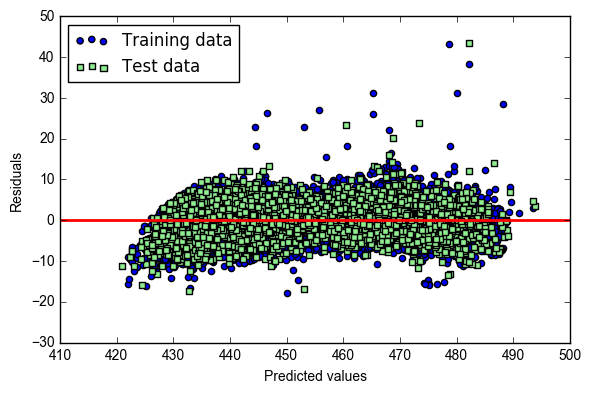

In [49]:
plt.scatter(y_train_pred,  y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=410, xmax=500, lw=2, color='red')
plt.xlim([410, 500])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

After executing the code, we should see a residual plot with a line passing through the x axis origin as shown.

In the case of a perfect prediction, the residuals would be exactly zero, which we will probably never encounter in realistic and practical applications. However, for a good regression model, we would expect that the errors are randomly distributed and the residuals should be randomly scattered around the centerline. If we see patterns in a residual plot, it means that our model is unable to capture some explanatory information, which is leaked into the residuals as we can slightly see in our preceding residual plot. Furthermore, we can also use residual plots to detect outliers, which are represented by the points with a large deviation from the centerline.

Another useful quantitative measure of a model's performance is the so-called Mean Squared Error (MSE), which is simply the average value of the SSE cost function that we minimize to fit the linear regression model. The MSE is useful to for comparing different regression models or for tuning their parameters via a grid search and cross-validation.

In [50]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 20.841, test: 20.603
R^2 train: 0.929, test: 0.929


We will see that the MSE on the training set is 20.841, and the MSE of the test set is lower with a value of 20.603.

Sometimes it may be more useful to report the coefficient of determination ( R2 ), which can be understood as a standardized version of the MSE, for better interpretability of the model performance. In other words, R2 is the fraction of response variance that is captured by the model. The R2 value is defined as follows: R^2 = 1 - (SSE / SST)

Here, SSE is the sum of squared errors and SST is the total sum of squares

For the training dataset, R^2 is bounded between 0 and 1, but it can become negative for the test set. If R^2 =1, the model fits the data perfectly with a corresponding MSE = 0 .

## Using regularized methods for regression

Regularization is one approach to tackle the problem of overfitting by
adding additional information, and thereby shrinking the parameter values of the
model to induce a penalty against complexity. The most popular approaches to
regularized linear regression are the so-called Ridge Regression, Least Absolute
Shrinkage and Selection Operator (LASSO) and Elastic Net method.

Ridge regression is an L2 penalized model where we simply add the squared sum of
the weights to our least-squares cost function.

By increasing the value of the hyperparameter lamda , we increase the regularization
strength and shrink the weights of our model. 
.
An alternative approach that can lead to sparse models is the LASSO. Depending
on the regularization strength, certain weights can become zero, which makes the
LASSO also useful as a supervised feature selection technique.

However, a limitation of the LASSO is that it selects at most n variables if m > n . A
compromise between Ridge regression and the LASSO is the Elastic Net, which has a
L1 penalty to generate sparsity and a L2 penalty to overcome some of the limitations
of the LASSO, such as the number of selected variables.

Those regularized regression models are all available via scikit-learn, and the
usage is similar to the regular regression model except that we have to specify the
regularization strength via the parameter  , for example, optimized via k-fold
cross-validation.

A Lasso Regression model can be initialized as follows:

In [51]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[-1.97481786 -0.23462441  0.06665247 -0.1569416 ]


In [52]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 20.841, test: 20.599
R^2 train: 0.929, test: 0.929


Similiarly Ridge regression can be used:

In [55]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)
print(ridge.coef_)

[-1.97976314 -0.23301377  0.06813079 -0.15838948]


Lastly, the ElasticNet implementation allows us to vary the L1 to L2 ratio:

In [56]:
from sklearn.linear_model import ElasticNet
en = ElasticNet(alpha=1.0, l1_ratio=0.5)
en.fit(X_train, y_train)
y_train_pred = en.predict(X_train)
y_test_pred = en.predict(X_test)
print(en.coef_)

[-1.85836784 -0.27739577  0.08487666 -0.1348257 ]


For example, if we set l1_ratio to 1.0, the ElasticNet regressor would be
equal to LASSO regression.

## Modeling nonlinear relationships in the dataset

By executing the following code, we will model the relationship between Energy Output PE and V (Exhaust Vacuum) using second degree (quadratic) and third degree (cubic) polynomials and compare it to a linear fit.

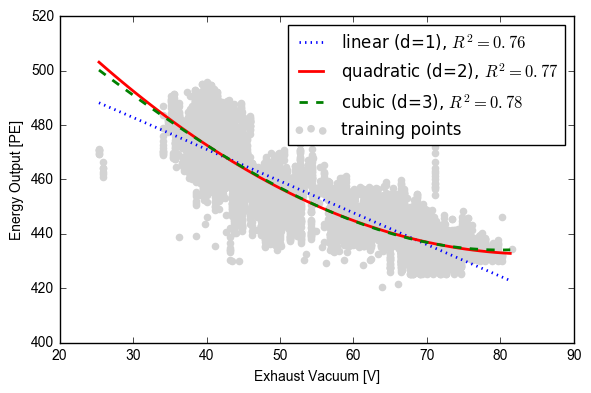

In [58]:
from sklearn.preprocessing import PolynomialFeatures

X = df[['V']].values
y = df['PE'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('Exhaust Vacuum [V]')
plt.ylabel('Energy Output [PE]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)
plt.show()

As we can see in the resulting plot, the cubic fit captures the relationship between the Energy Output [PE] and V better than the linear and quadratic fit. However, we should be aware that adding more and more polynomial features increases the complexity of a model and therefore increases the chance of overfitting. Thus, in practice, it is always recommended that you evaluate the performance of the model on a separate test dataset to estimate the generalization performance.

In addition, polynomial features are not always the best choice for modeling nonlinear relationships. For example, just by looking at the PE-V scatterplot, we could propose that a log transformation of the V feature variable and the square root of PE may project the data onto a linear feature space suitable for a linear regression fit. Let's test this hypothesis by executing the following code:

Transforming the dataset:

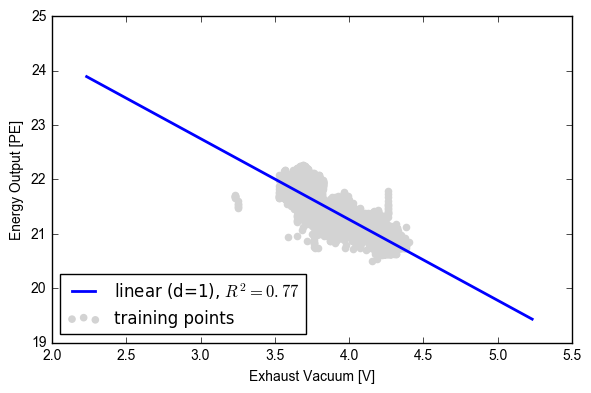

In [59]:
X = df[['V']].values
y = df['PE'].values

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('Exhaust Vacuum [V]')
plt.ylabel('Energy Output [PE]')
plt.legend(loc='lower left')

plt.tight_layout()
# plt.savefig('./figures/transform_example.png', dpi=300)
plt.show()

After transforming the explanatory onto the log space and taking the square root of the target variables, we were able to capture the relationship between the two variables with a linear regression line that seems to fit the data better ( R^2 = 0.69 ) than any of the polynomial feature transformations previously.

## Dealing with nonlinear relationships using random forests

In this section, we are going to take a look at random forest regression, which is
conceptually different from the previous regression models in this chapter. A random
forest, which is an ensemble of multiple decision trees, can be understood as the sum
of piecewise linear functions in contrast to the global linear and polynomial regression
models that we discussed previously. In other words, via the decision tree algorithm,
we are subdividing the input space into smaller regions that become more manageable.

## Decision tree regression

An advantage of the decision tree algorithm is that it does not require any
transformation of the features if we are dealing with nonlinear data. When we used decision trees for classification, we defined
entropy as a measure of impurity to determine which feature split maximizes the
Information Gain (IG).  

In the context of decision tree regression, the MSE is often also referred to as
within-node variance, which is why the splitting criterion is also better known
as variance reduction. To see what the line fit of a decision tree looks like, let's use
the DecisionTreeRegressor implemented in scikit-learn to model the nonlinear
relationship between the PE and V variables:


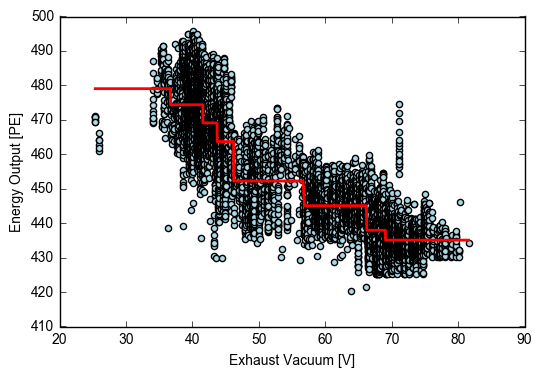

In [60]:
from sklearn.tree import DecisionTreeRegressor

X = df[['V']].values
y = df['PE'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Exhaust Vacuum [V]')
plt.ylabel('Energy Output [PE]')
# plt.savefig('./figures/tree_regression.png', dpi=300)
plt.show()

As we can see from the resulting plot, the decision tree captures the general
trend in the data. However, a limitation of this model is that it does not capture
the continuity and differentiability of the desired prediction. In addition, we
need to be careful about choosing an appropriate value for the depth of the tree
to not overfit or underfit the data; here, a depth of 3 seems to be a good choice.

## Random forest regression

The random forest algorithm is an ensemble technique that combines
multiple decision trees. A random forest usually has a better generalization
performance than an individual decision tree due to randomness that helps to
decrease the model variance. Other advantages of random forests are that they are
less sensitive to outliers in the dataset and don't require much parameter tuning.
The only parameter in random forests that we typically need to experiment with
is the number of trees in the ensemble. The basic random forests algorithm for
regression is almost identical to the random forest algorithm for classification , the only difference is that we use the MSE criterion to grow the individual decision
trees, and the predicted target variable is calculated as the average prediction over all
decision trees.

Now, let's use all the features in the Dataset to fit a random forest
regression model on 70 percent of the samples and evaluate its performance
on the remaining 30 percent. The code is as follows:

In [61]:
X = df[features].values
y = df['PE'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [62]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))


MSE train: 1.551, test: 11.253
R^2 train: 0.995, test: 0.961


Unfortunately, we see that the random forest just slightly tends to overfit the training data. However, it's still able to explain the relationship between the target and explanatory variables relatively well ( R^2 = 0.961 on the test dataset).

Lastly, let's also take a look at the residuals of the prediction:

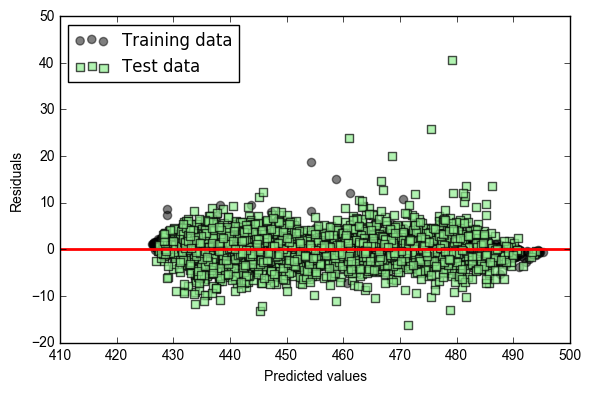

In [63]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='black', 
            marker='o', 
            s=35,
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='lightgreen', 
            marker='s', 
            s=35,
            alpha=0.7,
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=410, xmax=500, lw=2, color='red')
plt.xlim([410, 500])
plt.tight_layout()

# plt.savefig('./figures/slr_residuals.png', dpi=300)
plt.show()

As it was already summarized by the R^2 coefficient, we can see that the model
fits the training data better than the test data, as indicated by the outliers in the y
axis direction. Also, the distribution of the residuals does not seem to be completely
random around the zero center point, indicating that the model is not able to
capture all the exploratory information. However, the residual plot indicates a
large improvement over the residual plot of the linear model that we plotted
earlier in this chapter.

## Summary

At the beginning , you learned about using simple linear regression analysis to model the relationship between a single explanatory variable and a continuous response variable. We then discussed a useful explanatory data analysis technique to look at patterns and anomalies in data, which is an important first step in predictive modeling tasks.

We built our first model by implementing linear regression using a gradient-based optimization approach. We then saw how to utilize scikit-learn's linear models for regression and also implement a robust regression technique (RANSAC) as an approach for dealing with outliers. To assess the predictive performance of regression models, we computed the mean sum of squared errors and the related R^2 metric. Furthermore, we also discussed a useful graphical approach to diagnose the problems of regression models: the residual plot.

After we discussed how regularization can be applied to regression models to reduce the model complexity and avoid overfitting, we also introduced several approaches to model nonlinear relationships, including polynomial feature transformation and random forest regressors.

___